# Stepik ML contest (из курса [Введение в Data Science и машинное обучение](https://stepik.org/course/4852)) 

Рассмотрим в качестве практического проекта анализ активности студентов онлайн-курса Введение в анализ данных в R.

[events_train.csv](https://stepik.org/media/attachments/course/4852/event_data_train.zip) – данные о действиях, которые совершают студенты со стэпами:
- `step_id` – id стэпа
- `user_id` – анонимизированный id юзера
- `timestamp` – время наступления события в формате unix date
- `action` – событие, возможные значения: 
    - `discovered` – пользователь перешел на стэп
    - `viewed` – просмотр шага,
    - `started_attempt` – начало попытки решить шаг, ранее нужно было явно нажать на кнопку – начать решение, перед тем как приступить к решению практического шага
    - `passed` – удачное решение практического шага

[submissions_train.csv](https://stepik.org/media/attachments/course/4852/submissions_data_train.zip) – данные о времени и статусах сабмитов к практическим заданиям:
- `step_id` – id стэпа
- `timestamp` – время отправки решения в формате unix date
- `submission_status` – статус решения
- `user_id` – анонимизированный id юзера

Данные слишком объемны для хранения в репозитории, их можно забрать при помощи указанных ссылок. Так как это текстовые файлы, то их достаточно удобно хранить в сжатом виде. Функция `read_csv` умеет считывать данные из архивов «на лету».

In [1]:
import pandas as pd
import numpy as np

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set(rc={'figure.figsize': (9, 6)})

In [4]:
event_data_path = '../../data_for_courses/event_data_train.zip'
submissions_data_path = '../../data_for_courses/submissions_data_train.zip'

In [5]:
events_data = pd.read_csv(event_data_path)
submissions_data = pd.read_csv(submissions_data_path)

In [6]:
events_data.action.unique()

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

Преобразуем данные о времени из `timestamp` к человекочитаемому формату `datetime`.

In [7]:
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')

In [8]:
events_data.head()

,step_id,timestamp,action,user_id,date
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48
1,32815,1434340848,passed,17632,2015-06-15 04:00:48
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35


In [9]:
events_data['date'].min()

Timestamp('2015-06-15 04:00:48')

In [10]:
events_data['date'].max()

Timestamp('2018-05-19 23:33:31')

Видим, что представлены данные за три года.

Выделим отдельно день:

In [11]:
events_data['day'] = events_data.date.dt.date

In [12]:
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


Построим график активности:

<AxesSubplot:xlabel='day'>

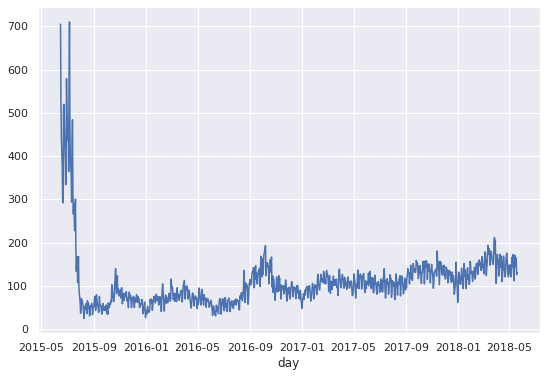

In [13]:
events_data.groupby('day') \
    .user_id.nunique().plot()

<AxesSubplot:>

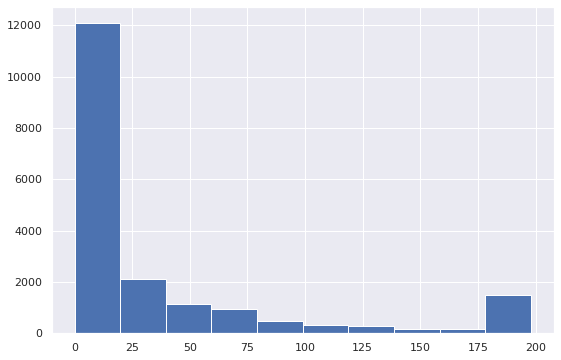

In [14]:
events_data.pivot_table(index='user_id',
                        columns='action',
                        values='step_id',
                        aggfunc='count',
                        fill_value=0).reset_index().discovered.hist()

In [15]:
users_events_data = events_data.pivot_table(index='user_id',
                        columns='action',
                        values='step_id',
                        aggfunc='count',
                        fill_value=0).reset_index()

Применим те же преобразования для второго датасета:

In [16]:
submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit='s')
submissions_data['day'] = submissions_data.date.dt.date

In [17]:
users_scores = submissions_data.pivot_table(index='user_id',
                        columns='submission_status',
                        values='step_id',
                        aggfunc='count',
                        fill_value=0)

In [18]:
users_scores.reset_index(inplace=True)

Рассчитаем распределение перерывов между занятиями.

In [19]:
gaps_data = events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['day'])\
    .groupby('user_id')['timestamp'].apply(list) \
    .apply(np.diff).values

In [20]:
gaps_data = pd.Series(np.concatenate(gaps_data, axis=0))

In [21]:
gaps_data = gaps_data / (24.0 * 60.0 * 60.0)  # в днях

In [22]:
gaps_data.quantile(0.90)

15.203456018518565

In [23]:
users_data = events_data.groupby('user_id', as_index=False)\
.agg({'timestamp':'max'}).rename(columns={'timestamp':'last_timestamp'})

In [24]:
now = events_data.timestamp.max() 
drop_out_threshold = 20 * 24* 3600
users_data['is_gone_user'] = (now - users_data.last_timestamp) > drop_out_threshold
users_data.head()

,user_id,last_timestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True


In [25]:
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [26]:
users_data = users_data.merge(users_scores, on='user_id', how='outer')

In [27]:
users_data.fillna(0, inplace=True)

In [28]:
users_data = users_data.merge(users_events_data, how = 'outer')

In [29]:
users_days = events_data.groupby('user_id').day.nunique().to_frame().reset_index()

In [30]:
users_data = users_data.merge(users_days, how='outer')

In [31]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,0.0,0.0,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,0.0,0.0,1,1,0,1,1


In [33]:
users_data.user_id.nunique()

19234

In [34]:
events_data.user_id.nunique()

19234

In [35]:
users_data['passed_course'] = users_data.passed > 170

In [40]:
pc = users_data.groupby('passed_course').count().reset_index()

In [41]:
pc

,passed_course,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
0,False,17809,17809,17809,17809,17809,17809,17809,17809,17809,17809
1,True,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425


Процент успешно прошедших курс:

In [46]:
pc['user_id'][1]/users_data.user_id.nunique()*100

7.408755329104711